In [21]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras import models

In [3]:
data_dir = "../data"  

# Funcion para contar número de imagenes en cada carpeta
def count_images_folders(root_dir):
    total = 0
    category_counts = {}
    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        if os.path.isdir(folder_path):
            emotion_count = {}
            num_images =  len(os.listdir(folder_path))             
            print(f"{num_images} images in {folder} folder")
            total += num_images
            print(f"Total images: {total}")
            category_counts[folder] = num_images

    return category_counts


# Contamos imagenes en train y test
print("Train Folder:")
train_category_counts = count_images_folders(os.path.join(data_dir, "train"))

print("\nTest Folder:")
test_category_counts = count_images_folders(os.path.join(data_dir, "test"))


Train Folder:
3995 images in angry folder
Total images: 3995
436 images in disgust folder
Total images: 4431
4097 images in fear folder
Total images: 8528
7215 images in happy folder
Total images: 15743
4965 images in neutral folder
Total images: 20708
4830 images in sad folder
Total images: 25538
3171 images in surprise folder
Total images: 28709

Test Folder:
958 images in angry folder
Total images: 958
111 images in disgust folder
Total images: 1069
1024 images in fear folder
Total images: 2093
1774 images in happy folder
Total images: 3867
1233 images in neutral folder
Total images: 5100
1247 images in sad folder
Total images: 6347
831 images in surprise folder
Total images: 7178


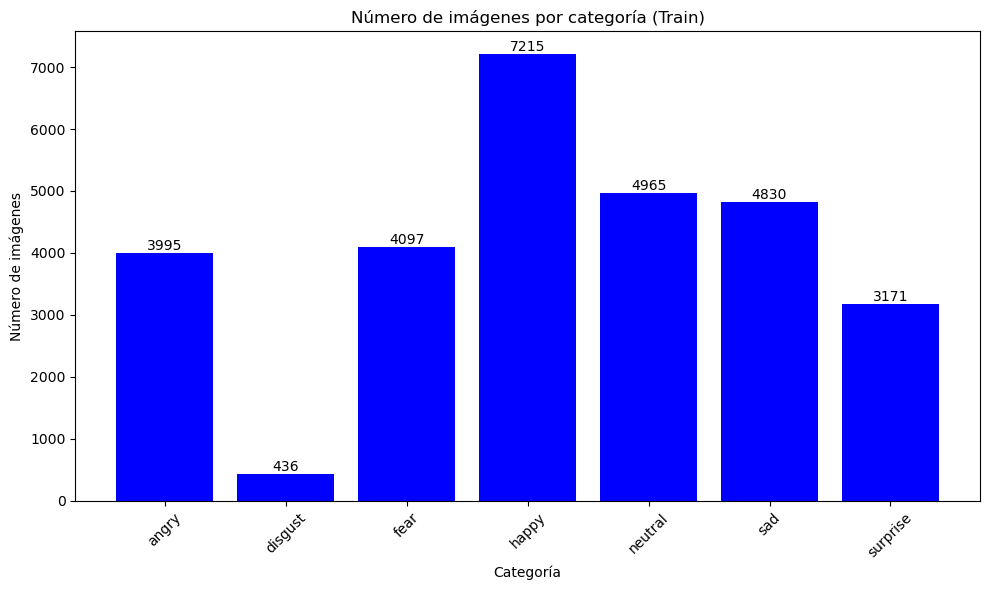

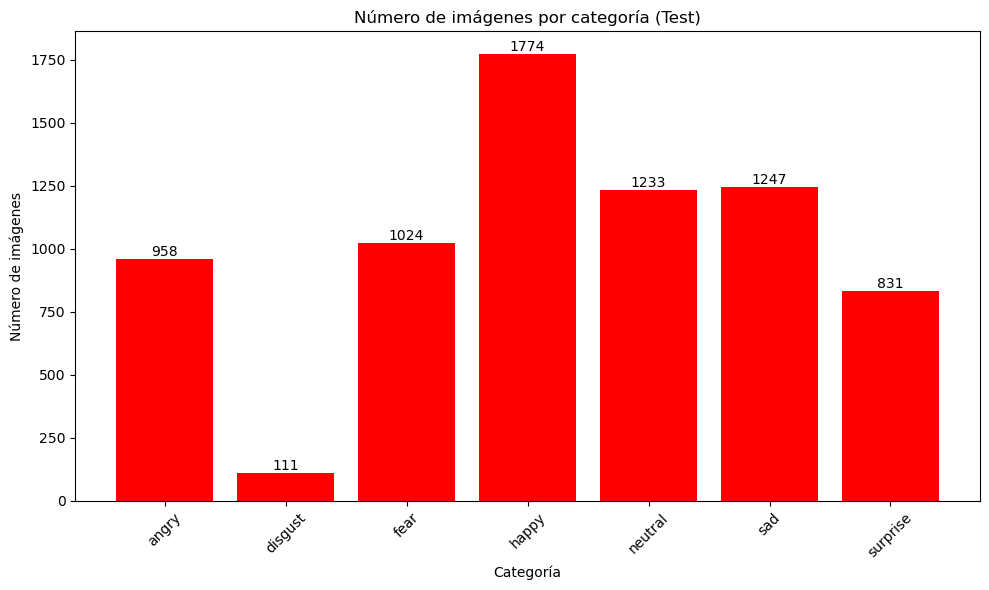

In [4]:
#Training
plt.figure(figsize=(10, 6))
plt.bar(train_category_counts.keys(), train_category_counts.values(), color='blue')
bars = plt.bar(train_category_counts.keys(), train_category_counts.values(), color='blue')
plt.title('Número de imágenes por categoría (Train)')
plt.xlabel('Categoría')
plt.ylabel('Número de imágenes')
plt.xticks(rotation=45)
plt.tight_layout()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

#Test
plt.figure(figsize=(10, 6))
plt.bar(test_category_counts.keys(), test_category_counts.values(), color='red')
bars = plt.bar(test_category_counts.keys(), test_category_counts.values(), color='red')
plt.title('Número de imágenes por categoría (Test)')
plt.xlabel('Categoría')
plt.ylabel('Número de imágenes')
plt.xticks(rotation=45)
plt.tight_layout()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

### CNN from scratch

In [7]:

# Define data directories
train_dir = "../data/train"
test_dir = "../data/test"

# Image dimensions and other parameters
img_width, img_height = 150, 150
batch_size = 32
num_epochs = 10

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

"""""
# Data augmentation for train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
"""""

'""\n# Data augmentation for train set\ntrain_datagen = ImageDataGenerator(\n    rescale=1./255,\n    rotation_range=15,\n    width_shift_range=0.1,\n    height_shift_range=0.1,\n    shear_range=0.1,\n    zoom_range=0.1,\n    horizontal_flip=True,\n    fill_mode=\'nearest\'\n)\n'

In [8]:
# Generate batches of image data (train and validation)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
def build_model(trial):
    model = Sequential()

    # Number of convolutional layers
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)

    # Add convolutional layers
    for i in range(num_conv_layers):
        filters = trial.suggest_int(f'filters_conv_{i}', 32, 128)
        kernel_size = trial.suggest_int(f'kernel_size_conv_{i}', 3, 5)
        model.add(Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), activation='relu', input_shape=(img_width, img_height, 3)))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Number of dense layers
    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 2)

    # Add dense layers
    for i in range(num_dense_layers):
        units = trial.suggest_int(f'units_dense_{i}', 64, 512)
        model.add(Dense(units=units, activation='relu'))
        #dropout_rate = trial.suggest_uniform(f'dropout_rate_{i}', 0.0, 0.5)
        #model.add(Dropout(dropout_rate))

    model.add(Dense(7, activation='softmax'))  # 7 output classes (emotions)

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [13]:
# Define the objective function for Optuna
def objective(trial):
    # Clear previous TensorFlow session
    tf.keras.backend.clear_session()

    # Define batch size and number of epochs as hyperparameters
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 5, 20)

    # Update batch size in data generators
    train_generator.batch_size = batch_size
    test_generator.batch_size = batch_size

    # Build the model
    model = build_model(trial)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=num_epochs,
        validation_data=test_generator,
        validation_steps=test_generator.samples // batch_size,
        verbose=0
    )

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)

    # Return the accuracy as the objective value to minimize
    return test_acc

In [14]:
import optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-27 23:06:13,725] A new study created in memory with name: no-name-90c0c2d0-7c3a-49ff-91d9-b611d32ce942
[W 2024-04-27 23:26:19,031] Trial 0 failed with parameters: {'batch_size': 128, 'num_epochs': 19, 'num_conv_layers': 2, 'filters_conv_0': 99, 'kernel_size_conv_0': 5, 'filters_conv_1': 82, 'kernel_size_conv_1': 5, 'num_dense_layers': 1, 'units_dense_0': 463} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\marta\anaconda3\envs\tf\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\marta\AppData\Local\Temp\ipykernel_14452\3617532707.py", line 18, in objective
    history = model.fit(
  File "c:\Users\marta\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "c:\Users\marta\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
    tmp_logs = self.

KeyboardInterrupt: 

In [15]:
best_trial = study.best_trial
best_params = best_trial.params

# por si se cambia el batch_size en optuna
batch_size = best_params['batch_size']  
train_generator.batch_size = batch_size
test_generator.batch_size = batch_size

optimum_model = build_model(best_trial)
optimum_model.summary()

ValueError: No trials are completed yet.

## Sin usar optuna, ir cambiando layers

In [16]:
batch_size = 128
num_epochs = 50
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [23]:
# Define the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
#Dropout(0.5),
model.add(layers.Dense(7, activation='softmax'))  # 7 output classes (emotions)


In [24]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("\nTest accuracy:", test_acc)

Epoch 1/50
224/224 [==============================] - 464s 2s/step - loss: 1.7076 - accuracy: 0.3296 - val_loss: 1.5320 - val_accuracy: 0.4107
Epoch 2/50
145/224 [==================>...........] - ETA: 2:44 - loss: 1.4519 - accuracy: 0.4398

KeyboardInterrupt: 

In [30]:
df_history = pd.DataFrame(history.history)
df_history.head()

,loss,accuracy,val_loss,val_accuracy
0,1.766091,0.274506,1.631213,0.328125
1,1.602893,0.368518,1.437288,0.444336
2,1.467506,0.431286,1.317225,0.500000
3,1.390934,0.463612,1.277931,0.505999
4,1.344937,0.484500,1.236630,0.525530


<Axes: title={'center': 'Losses'}, xlabel='Epochs', ylabel='Loss'>

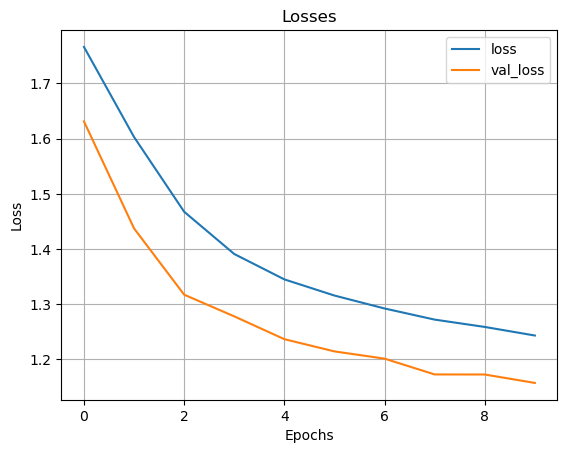

In [31]:
df_history['loss'].plot(legend=True)
df_history['val_loss'].plot(title='Losses', grid=True,
                              xlabel='Epochs',
                              ylabel='Loss',
                              legend=True)
     

<Axes: title={'center': 'Accuracies'}, xlabel='Epochs', ylabel='Accuracy'>

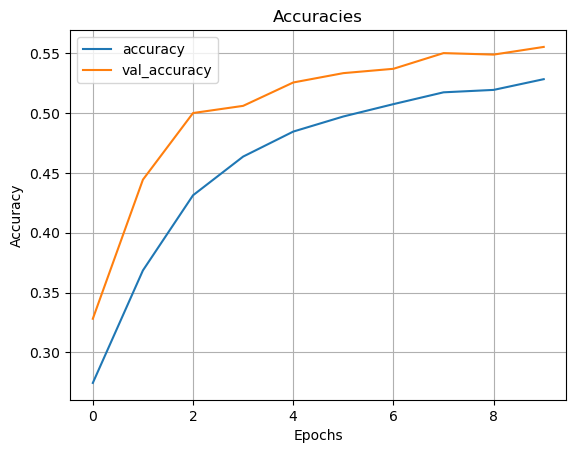

In [32]:
df_history['accuracy'].plot(legend=True)
df_history['val_accuracy'].plot(title='Accuracies', grid=True,
                              xlabel='Epochs',
                              ylabel='Accuracy',
                              legend=True)